# Bus Demand Forecasting - Analytics Vidhya Hackathon

## Problem Statement
Predict the demand (total number of seats booked) for each bus journey at the route level, **15 days before** the actual date of journey.

### Key Points:
- **Target**: Predict `final_seatcount` 15 days before the journey date
- **Evaluation Metric**: RMSE (Root Mean Squared Error)
- **Validation**: Last 10% of training data (time-based split)
- **Features**: Basic route and temporal features with 15-day advance booking data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Date and time

from datetime import datetime, timedelta

# Machine Learning
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from tqdm.auto import tqdm

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


print("Libraries imported and seed set!")

Libraries imported and seed set!


## 1. Data Loading

In [2]:
# Load the datasets
# Note: Update the file paths according to your local setup

train_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/train_JDXlpm8/train/train.csv')
test_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/test_8gqdJqH.csv')
transactions_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/train_JDXlpm8/train/transactions.csv')
submission_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/sample_submission_TQv3O0x.csv')

print("✅ All datasets loaded successfully!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Transactions shape: {transactions_df.shape}")
print(f"Submission shape: {submission_df.shape}")


# Convert date columns first
train_df['doj'] = pd.to_datetime(train_df['doj'])
test_df['doj'] = pd.to_datetime(test_df['doj'])
transactions_df['doj'] = pd.to_datetime(transactions_df['doj'])
transactions_df['doi'] = pd.to_datetime(transactions_df['doi'])

# Create validation split - last 10% of dates (time-based split)
unique_dates = sorted(train_df['doj'].unique())
val_date_count = int(len(unique_dates) * 0.1)
val_start_date = unique_dates[-val_date_count]

train_data = train_df[train_df['doj'] < val_start_date].copy()
val_data = train_df[train_df['doj'] >= val_start_date].copy()

print(f"\nTime-based validation split:")
print(f"Total unique dates: {len(unique_dates)}")
print(f"Validation dates: {val_date_count}")
print(f"Train date range: {train_data['doj'].min()} to {train_data['doj'].max()}")
print(f"Val date range: {val_data['doj'].min()} to {val_data['doj'].max()}")
print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")

print("Data loaded and validation split created!")

✅ All datasets loaded successfully!
Train shape: (67200, 4)
Test shape: (5900, 4)
Transactions shape: (2266100, 11)
Submission shape: (5900, 2)

Time-based validation split:
Total unique dates: 672
Validation dates: 67
Train date range: 2023-03-01 00:00:00 to 2024-10-25 00:00:00
Val date range: 2024-10-26 00:00:00 to 2024-12-31 00:00:00
Train shape: (60500, 4)
Validation shape: (6700, 4)
Data loaded and validation split created!


In [4]:
transactions_df.columns

Index(['doj', 'doi', 'srcid', 'destid', 'srcid_region', 'destid_region',
       'srcid_tier', 'destid_tier', 'cumsum_seatcount', 'cumsum_searchcount',
       'dbd'],
      dtype='object')

In [3]:
# Comprehensive Feature Engineering Function
def create_features(data, transactions_df, is_train=True):
    """
    Create a comprehensive set of features for the bus demand forecasting problem
    
    Features included:
    - Basic route features (srcid, destid)
    - Temporal features (day, month, quarter, weekday, etc.)
    - 15-day advance booking features from transactions
    - Route statistics (historical averages, frequency)
    - Interaction features
    - Lag features and rolling statistics
    """
    print(f"🔧 Creating features for {len(data)} records...")
    
    df = data.copy().reset_index(drop=True)
    
    # =====================================================
    # 1. BASIC FEATURES
    # =====================================================
    features = df[['srcid', 'destid']].copy()
    if is_train:
        features['target'] = df['final_seatcount']
    
    # =====================================================
    # 2. TEMPORAL FEATURES
    # =====================================================
    print("📅 Adding temporal features...")
    
    # Basic date features
    features['doj_year'] = df['doj'].dt.year
    features['doj_month'] = df['doj'].dt.month
    features['doj_day'] = df['doj'].dt.day
    features['doj_dayofweek'] = df['doj'].dt.dayofweek  # 0=Monday, 6=Sunday
    features['doj_quarter'] = df['doj'].dt.quarter
    features['doj_week'] = df['doj'].dt.isocalendar().week
    features['doj_dayofyear'] = df['doj'].dt.dayofyear
    
    # Weekend and month indicators
    features['is_weekend'] = (df['doj'].dt.dayofweek >= 5).astype(int)
    features['is_friday'] = (df['doj'].dt.dayofweek == 4).astype(int)
    features['is_monday'] = (df['doj'].dt.dayofweek == 0).astype(int)
    features['is_month_start'] = (df['doj'].dt.day <= 5).astype(int)
    features['is_month_end'] = (df['doj'].dt.day >= 25).astype(int)
    features['is_quarter_start'] = df['doj'].dt.month.isin([1, 4, 7, 10]).astype(int)
    features['is_quarter_end'] = df['doj'].dt.month.isin([3, 6, 9, 12]).astype(int)
    
    # Seasonal features
    features['season'] = features['doj_month'] % 12 // 3 + 1  # 1:Winter, 2:Spring, 3:Summer, 4:Fall
    features['is_summer'] = (features['season'] == 3).astype(int)
    features['is_winter'] = (features['season'] == 1).astype(int)
    
    # =====================================================
    # 3. 15-DAY ADVANCE BOOKING FEATURES
    # =====================================================
    
    # Get 15-day advance booking data
    filtered_tx = transactions_df[transactions_df['dbd'] == 15].copy()
    # Basic 15-day features
    booking_cols = ['srcid', 'destid', 'doj', 'cumsum_seatcount', 'cumsum_searchcount', 'srcid_tier', 'destid_tier']
    df_merged = df.merge(
        filtered_tx[booking_cols],
        on=['srcid', 'destid', 'doj'],
        how='left'
    ).reset_index(drop=True)
    # print(df_merged.head())
    # print(features.head())
    features['srcid_tier'] = df_merged['srcid_tier']
    features['destid_tier'] = df_merged['destid_tier']

    print("💰 Adding x-day booking features...")
    
    for i in [30,25,20,15]:
        filtered_tx = transactions_df[transactions_df['dbd'] == i].copy()
        df_merged = df.merge(
            filtered_tx[booking_cols],
            on=['srcid', 'destid', 'doj'],
            how='left'
        ).reset_index(drop=True)
        
        features[f'cumsum_seatcount_{i}d'] = df_merged['cumsum_seatcount']
        features[f'cumsum_searchcount_{i}d'] = df_merged['cumsum_searchcount']
        j=5
        while i+j<=30:
            features[f'cumsum_seatcount_{i+j}_{i}d'] = features[f'cumsum_seatcount_{i}d']-features[f'cumsum_seatcount_{i+j}d']
            features[f'cumsum_searchcount_{i+j}_{i}d'] = features[f'cumsum_searchcount_{i}d']-features[f'cumsum_searchcount_{i+j}d']
            j+=5

    
    # =====================================================
    # 4. ROUTE FEATURES & STATISTICS
    # =====================================================
    print("🗺️ Adding route features...")
    
    # Route identifier
    features['route_id'] = features['srcid'].astype(str) + '_' + features['destid'].astype(str)
    
    # Route type features
    features['same_city'] = (features['srcid'] == features['destid']).astype(int)
    features['route_distance_proxy'] = np.abs(features['srcid'] - features['destid'])
    
    
    
    # =====================================================
    # 5. INTERACTION FEATURES
    # =====================================================
    print("🔗 Adding interaction features...")
    
    features['tier_interaction'] = features['srcid_tier'].astype(str) + '_' + features['destid_tier'].astype(str)
    
    # =====================================================
    # 6. LAG AND ROLLING FEATURES (if sufficient data)
    # =====================================================
    
    # =====================================================
    # 7. DATA TYPE OPTIMIZATION
    # =====================================================
    print("🔧 Optimizing data types...")
    
    # Convert categorical features
    categorical_features = ['srcid', 'destid', 'srcid_tier', 'destid_tier', 'route_id', 'tier_interaction']
    
    for col in categorical_features:
        if col in features.columns:
            features[col] = features[col].astype('category')
    
    # Convert integer features
    int_features = ['doj_year', 'doj_month', 'doj_day', 'doj_dayofweek', 'doj_quarter', 
                   'doj_week', 'doj_dayofyear', 'season', 'is_weekend', 'is_friday', 
                   'is_monday', 'is_month_start', 'is_month_end', 'is_quarter_start', 
                   'is_quarter_end', 'is_summer', 'is_winter', 'same_city','route_distance_proxy']
    
    for col in int_features:
        if col in features.columns:
            features[col] = features[col].astype('int32')
    
    # Convert float features
    float_features = [col for col in features.columns if col not in categorical_features + int_features]
    for col in float_features:
        if col in features.columns:
            features[col] = features[col].astype('float32')
    
    print(f"✅ Feature engineering completed!")
    print(f"📊 Total features: {features.shape[1] - (1 if is_train else 0)} (excluding target)")
    print(f"💾 Memory usage: {features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return features

print("🚀 Comprehensive feature engineering function defined!")

# Create features for all datasets
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

print("Creating features for training data...")
train_features = create_features(train_data, transactions_df, is_train=True)

print("\nCreating features for validation data...")
val_features = create_features(val_data, transactions_df, is_train=True)

print("\nCreating features for test data...")
test_features = create_features(test_df, transactions_df, is_train=False)

# Prepare datasets
feature_cols = [col for col in train_features.columns if col != 'target']
X_train = train_features[feature_cols]
y_train = train_features['target']

X_val = val_features[feature_cols]
y_val = val_features['target']

X_test = test_features[feature_cols]

print(f"\n📊 FEATURE SUMMARY:")
print(f"Feature columns: {len(feature_cols)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

# Display feature types
print(f"\n🏷️ FEATURE TYPES:")
categorical_cols = X_train.select_dtypes(include=['category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int32', 'float32', 'int64', 'float64']).columns.tolist()

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols[:10]}..." if len(numeric_cols) > 10 else f"Numeric features ({len(numeric_cols)}): {numeric_cols}")

print("\n✅ Feature extraction completed!")

🚀 Comprehensive feature engineering function defined!

FEATURE ENGINEERING
Creating features for training data...
🔧 Creating features for 60500 records...
📅 Adding temporal features...
💰 Adding x-day booking features...
🗺️ Adding route features...
🔗 Adding interaction features...
🔧 Optimizing data types...
✅ Feature engineering completed!
📊 Total features: 45 (excluding target)
💾 Memory usage: 9.59 MB

Creating features for validation data...
🔧 Creating features for 6700 records...
📅 Adding temporal features...
💰 Adding x-day booking features...
🗺️ Adding route features...
🔗 Adding interaction features...
🔧 Optimizing data types...
✅ Feature engineering completed!
📊 Total features: 45 (excluding target)
💾 Memory usage: 1.08 MB

Creating features for test data...
🔧 Creating features for 5900 records...
📅 Adding temporal features...
💰 Adding x-day booking features...
🗺️ Adding route features...
🔗 Adding interaction features...
🔧 Optimizing data types...
✅ Feature engineering completed!
📊

## 3. Model Definitions

### 🎯 Approach 1: Traditional ML Models
- **Random Forest**: Good for capturing non-linear patterns
- **XGBoost/LightGBM**: Strong gradient boosting performance
- **Linear Models**: Ridge/Lasso for baseline

### 🎯 Approach 2: Time Series Models
- **ARIMA/SARIMA**: Classical time series forecasting
- **Prophet**: Facebook's time series tool
- **LSTM**: Deep learning for sequences

### 🎯 Approach 3: Ensemble Methods
- **Stacking**: Combine multiple models
- **Blending**: Weighted average of predictions
- **Cross-validation**: Time-series aware splits

### 🎯 Approach 4: Route-Specific Models
- **Individual route models**: Separate model per route
- **Clustering**: Group similar routes
- **Hierarchical models**: Route -> Region -> Global

In [5]:
def plot_monthly_sample_distribution(df, date_col='doj'):
    df['month'] = df[date_col].dt.to_period('M')
    monthly_counts = df['month'].value_counts().sort_index()

    print("📊 Monthly Sample Count:\n")
    display(monthly_counts)

    plt.figure()
    sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values)
    plt.title("Monthly Distribution of Journey Dates")
    plt.ylabel("Number of Samples")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def routewise_statistics(train_df):
    train_df['route'] = train_df['srcid'].astype(str) + '_' + train_df['destid'].astype(str)
    route_stats = train_df.groupby('route')['final_seatcount'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    
    print("📌 Top 10 Busiest Routes by Count:")
    display(route_stats.sort_values(by='mean', ascending=False).head(10))

    plt.figure()
    sns.histplot(route_stats['mean'], bins=30, kde=True)
    plt.title("Distribution of Mean Bookings per Route")
    plt.xlabel("Mean Final Seatcount")
    plt.show()

def tierwise_statistics(transactions_df):
    tier_stats = transactions_df.groupby(['srcid_tier', 'destid_tier'])['cumsum_seatcount'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()

    print("🏷️ Tier-wise Travel Statistics:")
    display(tier_stats)

    plt.figure()
    sns.boxplot(data=tier_stats, x='srcid_tier', y='mean', hue='destid_tier')
    plt.title("Tier-wise Mean Seat Booking Distribution")
    plt.ylabel("Mean Cumulative Seat Count")
    plt.xlabel("Source Tier")
    plt.show()

In [50]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# ===============================
# Load Data
# ===============================
train_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/train_JDXlpm8/train/train.csv')
test_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/test_8gqdJqH.csv')
transactions_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/train_JDXlpm8/train/transactions.csv')

# Date parsing
for df in [train_df, test_df]:
    df['doj'] = pd.to_datetime(df['doj'])
transactions_df['doj'] = pd.to_datetime(transactions_df['doj'])
transactions_df['doi'] = pd.to_datetime(transactions_df['doi'])

# ===============================
# Time-based Validation Split
# ===============================
unique_dates = sorted(train_df['doj'].unique())
val_date_count = int(len(unique_dates) * 0.4)
val_start_date = unique_dates[-val_date_count]
train_data = train_df[train_df['doj'] < val_start_date].copy()
val_data = train_df[train_df['doj'] >= val_start_date].copy()

# ===============================
# Feature Engineering Function
# ===============================
def preprocess_data(df, transactions_df):
    df = df.copy()

    df['route'] = df['srcid'].astype(str) + '_' + df['destid'].astype(str)
    df['week'] = df['doj'].dt.isocalendar().week.astype(int)
    df['day'] = df['doj'].dt.day
    df['dow'] = df['doj'].dt.weekday
    df['month'] = df['doj'].dt.month
    df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)
    df['day_of_year'] = df['doj'].dt.dayofyear

    # Merge Tier & Region Info
    tier_region_info = transactions_df[['doj', 'srcid', 'destid', 'srcid_tier', 'destid_tier', 'srcid_region', 'destid_region']].drop_duplicates()
    df = df.merge(tier_region_info, on=['doj', 'srcid', 'destid'], how='left')
    df['tier_pair'] = df['srcid_tier'].astype(str) + '_' + df['destid_tier'].astype(str)
    df['region_pair'] = df['srcid_region'].astype(str) + '_' + df['destid_region'].astype(str)

    # Add lag features (15, 20, 30)
    for lag in [15, 20, 30]:
        lag_data = transactions_df[transactions_df['dbd'] == lag][['doj', 'srcid', 'destid', 'cumsum_seatcount', 'cumsum_searchcount']]
        lag_data = lag_data.rename(columns={
            'cumsum_seatcount': f'seats_t{lag}',
            'cumsum_searchcount': f'searches_t{lag}'
        })
        df = df.merge(lag_data, on=['doj', 'srcid', 'destid'], how='left')

    # Route stats (only in train/val)
    if 'final_seatcount' in df.columns:
        route_stats = df.groupby('route')['final_seatcount'].agg(['mean', 'std', 'min', 'max']).reset_index()
        route_stats.columns = ['route', 'route_mean', 'route_std', 'route_min', 'route_max']
        df = df.merge(route_stats, on='route', how='left')

    df.fillna(-1, inplace=True)
    return df

# ===============================
# Training Function
# ===============================
def train_model(train_df, val_df, features):
    X_train = train_df[features]
    y_train = train_df['final_seatcount']
    X_val = val_df[features]
    y_val = val_df['final_seatcount']

    for cat in ['route', 'tier_pair', 'region_pair']:
        if cat in features:
            X_train[cat] = X_train[cat].astype('category')
            X_val[cat] = X_val[cat].astype('category')

    model = LGBMRegressor(
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=8,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        device = 'gpu'
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='rmse',
        # verbose=100,
        categorical_feature=['route', 'tier_pair', 'region_pair']
    )

    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    train_rmse = mean_squared_error(y_train, train_preds, squared=False)
    val_rmse = mean_squared_error(y_val, val_preds, squared=False)
    print(f"✅ Train RMSE: {train_rmse:.4f}")
    print(f"✅ Val RMSE: {val_rmse:.4f}")
    return model, val_preds

# ===============================
# Execute Pipeline
# ===============================
train_data_fe = preprocess_data(train_data, transactions_df)
val_data_fe = preprocess_data(val_data, transactions_df)

# Feature list
selected_features = [
    'route', 'week', 'searches_t15', 'day', 'seats_t15',
    'searches_t20', 'searches_t30', 'dow', 'seats_t20', 'seats_t30',
    'month', 'srcid', 'destid', 'tier_pair', 'region_pair', 'day_of_year'
]

# Train
model, val_preds = train_model(train_data_fe, val_data_fe, selected_features)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2030
[LightGBM] [Info] Number of data points in the train set: 40400, number of used features: 16
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 15 dense feature groups (0.62 MB) transferred to GPU in 0.001392 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1861.057599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [8]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import requests
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

# ===============================
# Load Data
# ===============================
train_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/train_JDXlpm8/train/train.csv')
test_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/test_8gqdJqH.csv')
transactions_df = pd.read_csv('/kaggle/input/redbus-data-decode-hackathon-2025/train_JDXlpm8/train/transactions.csv')

for df in [train_df, test_df]:
    df['doj'] = pd.to_datetime(df['doj'])
transactions_df['doj'] = pd.to_datetime(transactions_df['doj'])
transactions_df['doi'] = pd.to_datetime(transactions_df['doi'])

# ===============================
# Fetch Events from a Free API (Mocked with Calendarific)
# ===============================
CALENDARIFIC_API_KEY = "YOUR_CALENDARIFIC_API_KEY"

def fetch_single_event(date_str):
    url = f"https://calendarific.com/api/v2/holidays?&api_key={CALENDARIFIC_API_KEY}&country=IN&year={date_str[:4]}&month={int(date_str[5:7])}&day={int(date_str[8:10])}"
    try:
        res = requests.get(url)
        if res.status_code != 200:
            return []
        holidays = res.json().get('response', {}).get('holidays', [])
        return [{
            "date": pd.to_datetime(date_str),
            "event": hol['name'],
            "description": hol['description']
        } for hol in holidays]
    except:
        return []

def fetch_event_data(doj_list):
    doj_set = sorted(set(pd.to_datetime(doj_list).dt.strftime('%Y-%m-%d')))
    event_data = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(fetch_single_event, date): date for date in doj_set}
        for future in tqdm(as_completed(futures), total=len(futures)):
            event_data.extend(future.result())
    if not event_data:
        return pd.DataFrame(columns=['date', 'event', 'description'])
    return pd.DataFrame(event_data)


# ===============================
# Heuristic Relevance Scorer
# ===============================
def score_events(event_df):
    keywords = ["festival", "holiday", "celebration", "national", "observance", "religious", "regional"]
    scores = []
    for _, row in event_df.iterrows():
        text = (row['event'] + ' ' + row['description']).lower()
        score = any(kw in text for kw in keywords)
        scores.append(1.0 if score else 0.2)
    event_df['bus_travel_score'] = scores
    return event_df

# ===============================
# Time Split
# ===============================
def time_split(df, ratio=0.4):
    unique_dates = sorted(df['doj'].unique())
    split_index = int(len(unique_dates) * (1 - ratio))
    split_date = unique_dates[split_index]
    return df[df['doj'] < split_date].copy(), df[df['doj'] >= split_date].copy()

train_data, val_data = time_split(train_df)

# ===============================
# Feature Engineering
# ===============================
def preprocess(df, transactions_df, events_df):
    df = df.copy()
    df['route'] = df['srcid'].astype(str) + '_' + df['destid'].astype(str)
    df['week'] = df['doj'].dt.isocalendar().week.astype(int)
    df['day'] = df['doj'].dt.day
    df['dow'] = df['doj'].dt.weekday
    df['month'] = df['doj'].dt.month
    df['day_of_year'] = df['doj'].dt.dayofyear
    df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)

    tier_region = transactions_df[['doj', 'srcid', 'destid', 'srcid_tier', 'destid_tier', 'srcid_region', 'destid_region']].drop_duplicates()
    df = df.merge(tier_region, on=['doj', 'srcid', 'destid'], how='left')
    df['tier_pair'] = df['srcid_tier'].astype(str) + '_' + df['destid_tier'].astype(str)
    df['region_pair'] = df['srcid_region'].astype(str) + '_' + df['destid_region'].astype(str)

    for lag in [15, 20, 30]:
        lag_data = transactions_df[transactions_df['dbd'] == lag][['doj', 'srcid', 'destid', 'cumsum_seatcount', 'cumsum_searchcount']]
        lag_data = lag_data.rename(columns={
            'cumsum_seatcount': f'seats_t{lag}',
            'cumsum_searchcount': f'searches_t{lag}'
        })
        df = df.merge(lag_data, on=['doj', 'srcid', 'destid'], how='left')

    if 'final_seatcount' in df.columns:
        route_stats = df.groupby('route')['final_seatcount'].agg(['mean', 'std', 'min', 'max']).reset_index()
        route_stats.columns = ['route', 'route_mean', 'route_std', 'route_min', 'route_max']
        df = df.merge(route_stats, on='route', how='left')

    df = df.merge(events_df, left_on='doj', right_on='date', how='left')
    df['bus_travel_score'] = df['bus_travel_score'].fillna(0.0)
    df.drop(columns=['date'], errors='ignore', inplace=True)
    df.fillna(-1, inplace=True)
    return df

# ===============================
# Training
# ===============================
def train_model(train_df, val_df, features):
    X_train, y_train = train_df[features], train_df['final_seatcount']
    X_val, y_val = val_df[features], val_df['final_seatcount']

    for cat in ['route', 'tier_pair', 'region_pair']:
        if cat in features:
            X_train[cat] = X_train[cat].astype('category')
            X_val[cat] = X_val[cat].astype('category')

    model = LGBMRegressor(
        learning_rate=0.05, n_estimators=1000,
        max_depth=8, num_leaves=64,
        subsample=0.8, colsample_bytree=0.8, random_state=42, device = 'gpu'
    )
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              eval_metric='rmse', 
              categorical_feature=['route', 'tier_pair', 'region_pair'])

    train_rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)
    val_rmse = mean_squared_error(y_val, model.predict(X_val), squared=False)
    print(f"✅ Train RMSE: {train_rmse:.4f}")
    print(f"✅ Val RMSE: {val_rmse:.4f}")
    return model

# ===============================
# Submission
# ===============================
def submit(model, test_df, transactions_df, events_df, features):
    test_df = test_df.copy()
    test_df['route'] = test_df['srcid'].astype(str) + '_' + test_df['destid'].astype(str)
    test_df_fe = preprocess(test_df, transactions_df, events_df)
    for cat in ['route', 'tier_pair', 'region_pair']:
        if cat in features:
            test_df_fe[cat] = test_df_fe[cat].astype('category')
    test_preds = model.predict(test_df_fe[features])
    submission = pd.DataFrame({
        'route_key': test_df['route_key'],
        'final_seatcount': np.round(test_preds * 1.15).astype(int)
    })
    submission.to_csv("submission.csv", index=False)
    print("✅ submission.csv saved!")

# ===============================
# Run
# ===============================
event_df_raw = fetch_event_data(train_df['doj'])
event_df_scored = score_events(event_df_raw)

train_data_fe = preprocess(train_data, transactions_df, event_df_scored)
val_data_fe = preprocess(val_data, transactions_df, event_df_scored)

selected_features = [
    'route', 'week', 'day', 'dow', 'month', 'day_of_year',
    'is_weekend', 'seats_t15', 'searches_t15', 'seats_t20', 'searches_t20',
    'seats_t30', 'searches_t30', 'tier_pair', 'region_pair', 'bus_travel_score'
]

model = train_model(train_data_fe, val_data_fe, selected_features)
# submit(model, test_df, transactions_df, event_df_scored, selected_features)

100%|██████████| 672/672 [00:14<00:00, 46.71it/s]


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1940
[LightGBM] [Info] Number of data points in the train set: 40300, number of used features: 15
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (0.61 MB) transferred to GPU in 0.001533 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 1860.272382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [9]:
submit(model, test_df, transactions_df, event_df_scored, selected_features)

✅ submission.csv saved!


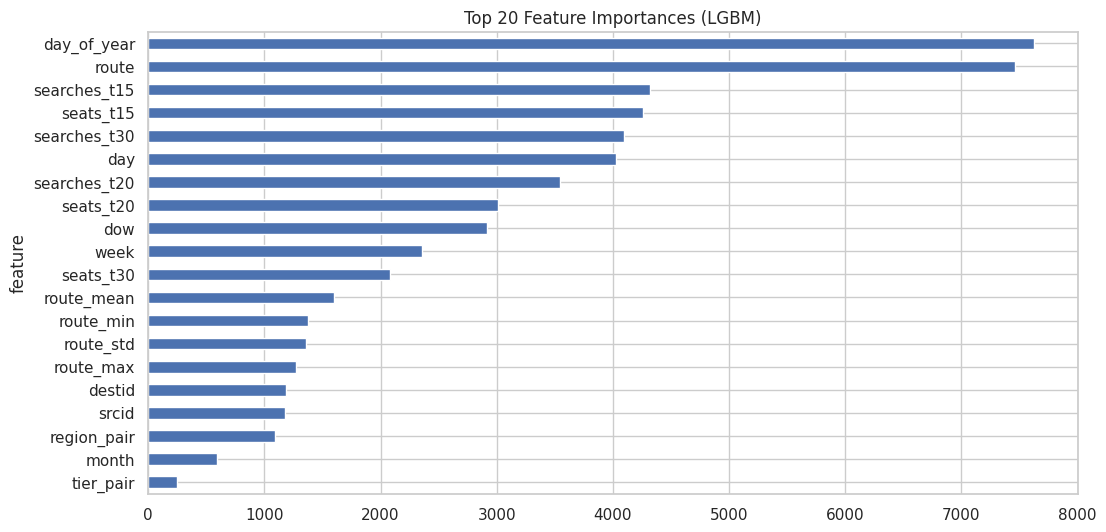

In [33]:
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    feat_imp = pd.DataFrame({'feature': features, 'importance': importances})
    feat_imp.sort_values(by='importance', ascending=False).head(20).plot(
        kind='barh', x='feature', y='importance', legend=False)
    plt.title("Top 20 Feature Importances (LGBM)")
    plt.gca().invert_yaxis()
    plt.show()
plot_feature_importance(model,selected_features)

In [36]:
test_df.head()

,route_key,doj,srcid,destid
0,2025-02-11_46_45,2025-02-11,46,45
1,2025-01-20_17_23,2025-01-20,17,23
2,2025-01-08_02_14,2025-01-08,2,14
3,2025-01-08_08_47,2025-01-08,8,47
4,2025-01-08_09_46,2025-01-08,9,46


In [41]:
submission_df.head()

,route_key,final_seatcount
0,2025-02-11_46_45,0
1,2025-01-20_17_23,0
2,2025-01-08_02_14,0
3,2025-01-08_08_47,0
4,2025-01-08_09_46,0


## 5. Generate Submission

In [51]:
def get_submission(model, test_df, transactions_df, selected_features):
    test_df_fe = preprocess_data(test_df, transactions_df)
    for cat in ['route', 'tier_pair', 'region_pair']:
        if cat in selected_features:
            test_df_fe[cat] = test_df_fe[cat].astype('category')
    missing_cols = [col for col in selected_features if col not in test_df_fe.columns]
    if missing_cols:
        print(f"⚠️ Warning: missing columns in test data: {missing_cols}")
        for col in missing_cols:
            test_df_fe[col] = -1
    X_test = test_df_fe[selected_features]
    test_preds = model.predict(X_test)
    submission = pd.DataFrame({
        'route_key': test_df['route_key'],
        'final_seatcount': np.round(test_preds * 1.15).astype(int)
    })
    submission.to_csv('submission.csv', index=False)
    print("✅ Submission file 'submission.csv' created!")


# Submit
get_submission(model, test_df, transactions_df, selected_features)

✅ Submission file 'submission.csv' created!


In [52]:
sub = pd.read_csv('/kaggle/working/submission.csv')

In [53]:
sub.head()

,route_key,final_seatcount
0,2025-02-11_46_45,4253
1,2025-01-20_17_23,1455
2,2025-01-08_02_14,1247
3,2025-01-08_08_47,1056
4,2025-01-08_09_46,3916
